# Topic Modelling
- abstracts are to be tagged for descriptive analysis (ideally with the studied disease, cell type etc.)
- there are three typically used algorithms for topic modelling:
    - Latent Semantic Analysis (LSA)
    - Latent Dirichlet Allocation (LDA)
    - non-negative matrix factorization (NMF)
- for LSA it's difficult to distinguish between the different meanings of one word, which is why LSA will only be tried if there is time remaining
- LDA is able to recognize synonyms and distingiush between the different meanings of a word
- NMF has already been used to 'tag' abstracts (Nielsen *et al.* 2005, https://www.ncbi.nlm.nih.gov/pubmed/15946864)

In [1]:
import pandas as pd
import numpy as np

# Imports for word cloud
from wordcloud import WordCloud
import PIL
import itertools
import matplotlib.pyplot as plt

import nltk
from gensim import corpora, models
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from gensim import similarities
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

C:\Users\Kaddi\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaddi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('../data/save.csv', index_col=0)

C:\Users\Kaddi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(data)

66240

In [4]:
text = data['clean_abstracts']

### Replacing of 'short names' with 'actual names'
- to ensure that the different forms of vitamin D are recognised properly by the algorithm, the short version with numbers are replaced with the actual names
    - the different writing styles are checkt via str.extract and used for filter buiding
    - the efficiency of the filter is checked by counting the occurrences of 1,25 and 25-
- since the 'd' of 'vitamin d' is so short, it is always removed, this is why the 'd' is fused to the 'vitamin'

In [5]:
def easy_words(column):
    text = column.str.lower()
    
    text = text.str.replace('1,25\S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25\S+ vit d', 'calcitriol')
    text = text.str.replace('1,25\S+', 'calcitriol')

    text = text.str.replace('1,25 vitamin d', 'calcitriol')
    text = text.str.replace('1,25 vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vitamin d', 'calcitriol')
    text = text.str.replace('1,25 \S+ vit d', 'calcitriol')
    text = text.str.replace('1,25 \S+ d', 'calcitriol')
    text = text.str.replace('1,25 \S+', 'calcitriol')
    
    text = text.str.replace('25\S+ vitamin d', 'calcidiol')
    text = text.str.replace('25\S+ vit d', 'calcidiol')
    text = text.str.replace('25\S+', 'calcidiol')
 
    text = text.str.replace('vitamin d', 'vitamind')
    text = text.str.replace('vit d', 'vitamind')
    
    text = text.str.replace('tb', 'tuberculosis')
    
    return text

In [6]:
text = easy_words(text)

Remove 'vitamin d' and its derivates entirely, because very topic will be vitamin d, obviously.

In [7]:
text = text.str.replace('vitamind', '')
text = text.str.replace('calcitriol', '')
text = text.str.replace('calcidiol', '')

In [8]:
list_125 = text.str.extract('(1,25)')
list_125[list_125[0].str.contains('NaN') == False].count()

0    199
dtype: int64

In [9]:
list_25 = text.str.extract('(25-)')
list_25[list_25[0].str.contains('NaN') == False].count()

0    0
dtype: int64

In [10]:
list_tb = text.str.extract('(tb)')
list_tb[list_tb[0].str.contains('NaN') == False].count()

0    0
dtype: int64

### Word Clouds
- to evaluate the most prominent words in an abstract, word clouds are used
- aim: to improve the stopword list with science/medical specific terms

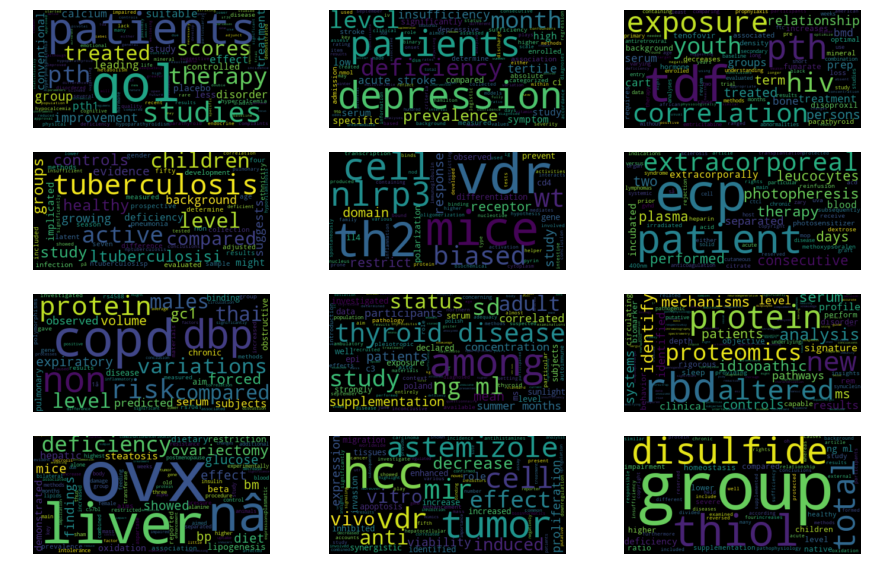

In [11]:
plt.figure(1, figsize=(15,10))

for entry in range(0,12):
    raw_str = text.iloc[entry]
    wordcloud = WordCloud(max_words=1000,margin=0).generate(raw_str)
    
    plt.subplot(4,3, 1 + entry)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
plt.show()

The most used words in the abstracts are often not very descriptive (e.g. rio de janeiro, university, patient, vitamind)

### MVP: LDA
- for the MVP all of the abstract is used to determine a topic
- the abstract is not formatted in any way, except for the easy_words function, the removal of non-letter characters and the splitting in single words

In [12]:
NUM_TOPICS_abstracts =10
STOPWORDS = stopwords.words('english')

In [13]:
split_text = text.str.split()

In [14]:
clean_text = []

for entry in range(0,len(split_text)):
    clean_text.append([word for word in split_text.iloc[entry] if word not in
                       STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}',
                                              word)])

In [15]:
dictionary_abstracts = corpora.Dictionary(clean_text)
print(dictionary_abstracts)

Dictionary(191496 unique tokens: ['addition,', 'adequately', 'adjunct', 'also', 'although']...)


In [16]:
corpus_abstracts = [dictionary_abstracts.doc2bow(text) for text in clean_text]

In [17]:
# Build LDA model
lda_model = models.LdaModel(corpus=corpus_abstracts, num_topics=NUM_TOPICS_abstracts, 
                            id2word=dictionary_abstracts)

In [18]:
for idx in range(NUM_TOPICS_abstracts):
    print("Topics #%s:" % idx, lda_model.print_topic(idx, 3))

Topics #0: 0.025*"patients" + 0.014*"fracture" + 0.013*"fractures"
Topics #1: 0.036*"rats" + 0.015*"diet" + 0.015*"vitamin"
Topics #2: 0.034*"bone" + 0.029*"calcium" + 0.015*"serum"
Topics #3: 0.023*"serum" + 0.015*"levels" + 0.011*"intake"
Topics #4: 0.017*"cells" + 0.011*"cell" + 0.008*"protein"
Topics #5: 0.016*"calcium" + 0.009*"bone" + 0.007*"chick"
Topics #6: 0.015*"treatment" + 0.008*"may" + 0.007*"clinical"
Topics #7: 0.008*"risk" + 0.007*"rickets" + 0.007*"exposure"
Topics #8: 0.050*"author" + 0.050*"information:" + 0.018*"university"
Topics #9: 0.036*"patients" + 0.022*"serum" + 0.021*"parathyroid"


Unclean text is chosen as topic (e.g. 'pmid:' or 'medline]') and the topics are very general in their description.

### Improving the topic modeling with LDA
- maybe using the headlines will give more descriptive topics

In [19]:
titles = easy_words(data['title'])
titles = titles.str.replace('vitamind', '')
titles = titles.str.replace('calcitriol', '')
titles = titles.str.replace('calcidiol', '')
titles = titles.str.replace('rats', '')
titles = titles.dropna()

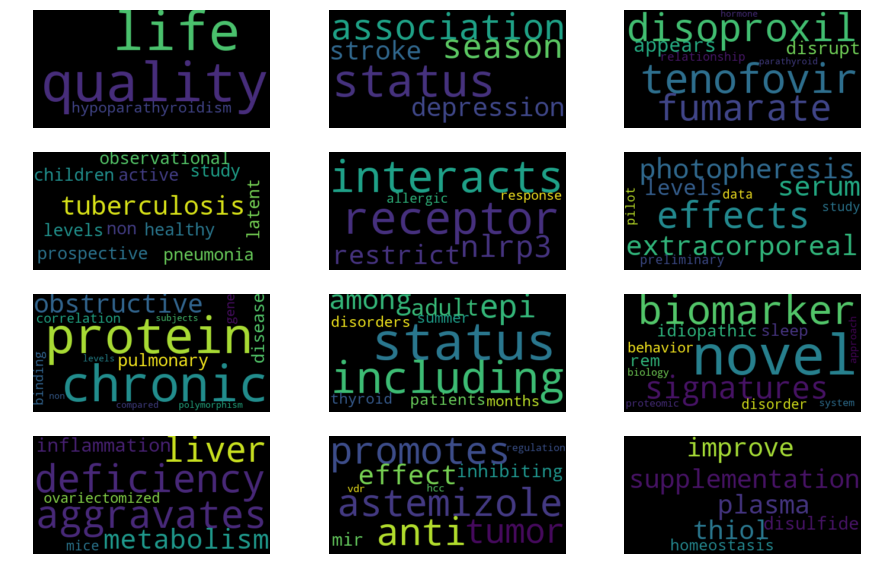

In [20]:
plt.figure(1, figsize=(15,10))

for entry in range(0,12):
    raw_str = titles.iloc[entry]
    wordcloud = WordCloud(max_words=1000,margin=0).generate(raw_str)
    
    plt.subplot(4,3, 1 + entry)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

plt.show()

The most used words of the headlines seem too detailed to be a topic.

In [21]:
titles_split = titles.str.split()

In [22]:
NUM_TOPICS_titles = 12

In [23]:
clean_titles = []

for entry in range(0,len(titles_split)):
    clean_titles.append([word for word in titles_split.iloc[entry] if word not in
                        STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}',
                                              word)])

In [24]:
titles_dictionary = corpora.Dictionary(clean_titles)
print(titles_dictionary)

Dictionary(35090 unique tokens: ['hypoparathyroidism', 'life', 'quality', 'association', 'depression']...)


In [25]:
titles_corpus = [titles_dictionary.doc2bow(text) for text in clean_titles]

In [26]:
# Build LDA model
lda_model = models.LdaModel(corpus=titles_corpus, num_topics=NUM_TOPICS_titles, 
                            id2word=titles_dictionary)

In [27]:
for idx in range(NUM_TOPICS_titles):
    print("Topics #%s:" % idx, lda_model.print_topic(idx, 3))

Topics #0: 0.052*"renal" + 0.037*"patients" + 0.036*"chronic"
Topics #1: 0.086*"rickets" + 0.052*"absorption" + 0.030*"lupus"
Topics #2: 0.128*"bone" + 0.060*"metabolism" + 0.029*"mineral"
Topics #3: 0.030*"human" + 0.025*"cells" + 0.024*"cell"
Topics #4: 0.059*"calcium" + 0.043*"effect" + 0.023*"milk"
Topics #5: 0.035*"gene" + 0.034*"receptor" + 0.030*"upon"
Topics #6: 0.071*"parathyroid" + 0.055*"phosphorus" + 0.055*"hormone"
Topics #7: 0.055*"calciferol" + 0.029*"vitro" + 0.029*"treatment"
Topics #8: 0.063*"rat" + 0.031*"cells" + 0.021*"effect"
Topics #9: 0.048*"calcium" + 0.029*"intestinal" + 0.025*"osteomalacia"
Topics #10: 0.033*"determination" + 0.026*"vitamin" + 0.026*"vitamins"
Topics #11: 0.064*"studies" + 0.039*"treatment" + 0.018*"cases"


The topics for the headlines are more diverse and descriptive. 'Vitamin D and bones (e.g. osteoporosis, rickets)' is a big research topic, as well as 'kidneys and vitamin D' or 'vitamin D receptor mutations'. However, cancer and autoimmune diseases are missing.

### MVP - NMF

In [28]:
tfidf_vectorizer_text = TfidfVectorizer(max_features=len(text), stop_words='english')
tfidf_text = tfidf_vectorizer_text.fit_transform(text)
tfidf_feature_names_text = tfidf_vectorizer_text.get_feature_names()

In [29]:
no_topics_text = 10

In [30]:
nmf_text = NMF(n_components=no_topics_text, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_text)

In [31]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print( "Topic %d:" % (topic_idx))
        print( " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words_text = 3
display_topics(nmf_text, tfidf_feature_names_text, no_top_words_text)

Topic 0:
serum levels deficiency
Topic 1:
cells cell d3
Topic 2:
bone bmd mineral
Topic 3:
osteoporosis fracture fractures
Topic 4:
calcium absorption rats
Topic 5:
patients pth levels
Topic 6:
university author department
Topic 7:
vdr gene receptor
Topic 8:
group placebo groups
Topic 9:
cancer breast prostate


The topics are more diverse than with LDA, but also more repetitive (e.g. bone/bmd, fracture/fractures), so a lot more cleaning is needed.
Maybe the model will perform better on the headlines. Otherwise, Count Vectorize instead of TF-IDF will be tested as preprocessing, as I am not sure, that TF-IDF will actually get the best words, since the abstracts are kind of similar and should be (as in: I would like all the cancer abstracts in one group, even though TF-IDF would probaby rank this word down).

### Improving the topic modeling with NMF

In [32]:
tfidf_vectorizer_titles = TfidfVectorizer(max_features=len(titles), stop_words='english')
tfidf_titles = tfidf_vectorizer_titles.fit_transform(titles)
tfidf_feature_names_titles = tfidf_vectorizer_titles.get_feature_names()

In [33]:
no_topics_titles = 10

In [34]:
nmf_titles = NMF(n_components=no_topics_titles, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_titles)

In [35]:
no_top_words_titles = 3
display_topics(nmf_titles, tfidf_feature_names_titles, no_top_words_titles)

Topic 0:
bone mineral density
Topic 1:
d3 cells human
Topic 2:
serum levels patients
Topic 3:
osteoporosis treatment prevention
Topic 4:
calcium metabolism absorption
Topic 5:
parathyroid hormone renal
Topic 6:
disease chronic kidney
Topic 7:
supplementation trial randomized
Topic 8:
cancer receptor gene
Topic 9:
deficiency rickets children


In topic 5 it's obvious that the headlines aren't properly extracted. Topics are better but still a bit repepetive (calitriol/d3).
Count Vectorize will bei tried instead of TF-IDF.

In [36]:
tf_vectorizer_titles = CountVectorizer(max_features=len(titles), stop_words='english')
tf_titles = tf_vectorizer_titles.fit_transform(titles)
tf_feature_names_titles = tf_vectorizer_titles.get_feature_names()

In [37]:
nmf_titles = NMF(n_components=no_topics_titles, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf_titles)

In [38]:
display_topics(nmf_titles, tf_feature_names_titles, no_top_words_titles)

Topic 0:
bone mineral density
Topic 1:
d3 alpha 1alpha
Topic 2:
patients deficiency hyperparathyroidism
Topic 3:
calcium metabolism intestinal
Topic 4:
study risk cancer
Topic 5:
receptor gene polymorphisms
Topic 6:
serum levels hormone
Topic 7:
disease chronic kidney
Topic 8:
cells human cell
Topic 9:
treatment trial randomized


Except for topic 1 the topics are better than with TF-IDF. Let's see, if using the whole abstract will unexpectantly lead to a better result.

In [39]:
tf_vectorizer_text = CountVectorizer(max_features=len(text), stop_words='english')
tf_text = tf_vectorizer_text.fit_transform(text)
tf_feature_names_text = tf_vectorizer_text.get_feature_names()

nmf_text = NMF(n_components=no_topics_text, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tf_text)

display_topics(nmf_text, tf_feature_names_text, no_top_words_text)

Topic 0:
serum pth concentrations
Topic 1:
cells cell expression
Topic 2:
bone bmd mineral
Topic 3:
risk 95 women
Topic 4:
patients disease treatment
Topic 5:
university department medicine
Topic 6:
calcium pth intake
Topic 7:
group groups treatment
Topic 8:
vdr receptor gene
Topic 9:
levels ml ng


Using CountVectorizer with abstracts does not lead to a better topic modeling result - the abstracts would need to be properly cleaned.